# 随机梯度下降法

#### 1.导入数据

In [4]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

def data_tf(x):
    x=np.array(x,dtype='float32')/255
    x=(x-0.5)/0.5
    x=x.reshape((-1,))# 展开为一个维度
    return x
train_set=MNIST('../data',train=True,transform=data_tf,download=True) #
test_set=MNIST('../data',train=False,transform=data_tf,download=True)

#定义损失函数
criterion=nn.CrossEntropyLoss()

#### 2.SGD公式:
随机梯度下降法非常简单，公式就是
$$
\theta_{i+1} = \theta_i - \eta \nabla L(\theta)
$$
非常简单，我们可以从 0 开始自己实现

## 一.自己实现SGD优化函数

In [11]:
#定义SGD函数
def sgd_update(parameters,lr):
    for param in parameters:
        param.data=param.data-lr* param.grad.data

### 1. batch_size=1的情况

In [14]:
train_data=DataLoader(train_set,batch_size=1,shuffle=True)
#使用Sequential定义模型
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))
#开始训练
losses1=[]
idx=0
start=time.time() #及时开始

for e in range(5):
    train_loss=0
    for im,label in train_data:
        im=Variable(im)
        label=Variable(label)
        #前向传播
        out=net(im)
        loss=criterion(out,label)
        #反向传播
        net.zero_grad()
        loss.backward() #别忘了这句话
        sgd_update(net.parameters(),1e-2)
        
        train_loss+=loss.item()#最好用 loss.item(),loss.data[0]即将失效!
        if idx%30==0:
            losses1.append(loss.item())
        idx+=1
    print('epoch:{},Train Loss:{:.6f}'.format(e,train_loss/len(train_data)))
end=time.time()
print('使用时间:{:.5f}s'.format(end-start))

epoch:0,Train Loss:0.345843
epoch:1,Train Loss:0.214770
epoch:2,Train Loss:0.180623
epoch:3,Train Loss:0.158165
epoch:4,Train Loss:0.147694
使用时间:168.88484s


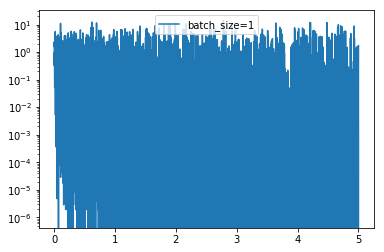

In [16]:
x_axis=np.linspace(0,5,len(losses1),endpoint=True)
plt.semilogy(x_axis,losses1,label='batch_size=1')
plt.legend(loc='best')

### 2.batch_size=64的情况

In [18]:
train_data=DataLoader(train_set,batch_size=64,shuffle=True)
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))
losses2=[]
idx=0
start=time.time()
for e in range(5):
    train_loss=0
    for im,label in train_data:
        im=Variable(im)
        label=Variable(label)
        out=net(im)
        loss=criterion(out,label)
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(),0.01)
        train_loss+=loss.item()
        if idx%30==0:
            losses2.append(loss.item())
        idx+=1
    print('epoch:{},Train Loss:{:.6f}'.format(e,train_loss/len(train_data)))
end=time.time()
print('Used {:.6f}s'.format(end-start))

epoch:0,Train Loss:0.734472
epoch:1,Train Loss:0.364277
epoch:2,Train Loss:0.319621
epoch:3,Train Loss:0.292733
epoch:4,Train Loss:0.271362
Used 26.340400s


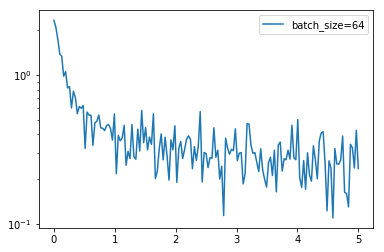

In [19]:
x_axis=np.linspace(0,5,len(losses2),endpoint=True)
plt.semilogy(x_axis,losses2,label='batch_size=64')
plt.legend(loc='best')

batch_size=1和batch_size=64相比,大一点batch不仅训练时间少,而且loss不会那个震荡.但是过大的batch_size不利用跳出局部极小点.

### 3. lr=1时候的情况

In [20]:
train_data=DataLoader(train_set,batch_size=64,shuffle=True)
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))
losses3=[]
idx=0
start=time.time()
for e in range(5):
    train_loss=0
    for im,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(),lr=1.)
        train_loss+=loss.item()
        if idx%30==0:
            losses3.append(loss.item())
        idx+=1
    print('epoch:{},loss:{:.5f}'.format(e,train_loss/len(train_data)))
print('Used {:.5f}s'.format(time.time()-start))

epoch:0,loss:2.53282
epoch:1,loss:2.30647
epoch:2,loss:2.30486
epoch:3,loss:2.30510
epoch:4,loss:2.30500
Used 26.07081s


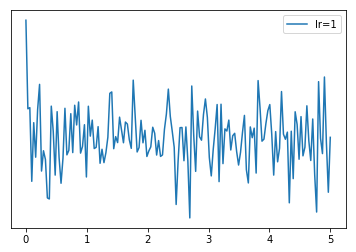

In [21]:
x_axis=np.linspace(0,5,len(losses3),endpoint=True)
plt.semilogy(x_axis,losses3,label='lr=1')
plt.legend(loc='best')

用SGD方法,如果lr学习率设置的太大就会导致loss不会收敛.

## 二.使用pytorch自带的优化器实现SGD-`torch.optim.SGD(model.parameters(),lr=)`

In [22]:
train_data=DataLoader(train_set,batch_size=64,shuffle=True)
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))
optimizer=torch.optim.SGD(net.parameters(),0.01)
start=time.time()
for e in range(5):
    train_loss=0
    for im,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    print('epoch:{},loss:{:.5f}'.format(e,train_loss))
print('Used {:.5f}s'.format(time.time()-start))

epoch:0,loss:714.54659
epoch:1,loss:342.84689
epoch:2,loss:298.51047
epoch:3,loss:271.64834
epoch:4,loss:250.63819
Used 25.77516s
